# LSTM for Time Series

The dataset source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-02-11 16:24:56--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2,1K) [text/plain]
Saving to: ‘airline-passengers.csv.3’

airline-passengers. 100%[===================>]   2,13K  --.-KB/s    in 0s      

2023-02-11 16:24:56 (28,2 MB/s) - ‘airline-passengers.csv.3’ saved [2180/2180]



In [2]:
from sklearn.preprocessing import MinMaxScaler


# Load data
with open("airline-passengers.csv", mode="r") as fp:
    fp.readline()
    data = [[float(line.split(",")[1])] for line in fp.readlines()]


# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [4]:
from neuralogic.core import R


window_size = 4

examples = []
queries = []

for i in range(len(scaled_data) - window_size - 1):
    example = []
    
    for index, value in enumerate(scaled_data[i:i + window_size]):
        example.append(R.x(index + 1)[value[0]])
    examples.append(example)
    queries.append(R.predict[scaled_data[i + window_size][0]])

In [5]:
# Print first three queries and examples
for query, example in zip(queries[:3], examples[:3]):
    print("Query:", query, "Examples:", ", ".join(str(e) for e in example))

Query: 0.03281853281853281 predict. Examples: 0.015444015444015441 x(1)., 0.02702702702702703 x(2)., 0.05405405405405403 x(3)., 0.04826254826254825 x(4).
Query: 0.05984555984555981 predict. Examples: 0.02702702702702703 x(1)., 0.05405405405405403 x(2)., 0.04826254826254825 x(3)., 0.03281853281853281 x(4).
Query: 0.08494208494208491 predict. Examples: 0.05405405405405403 x(1)., 0.04826254826254825 x(2)., 0.03281853281853281 x(3)., 0.05984555984555981 x(4).


In [6]:
train_size = int(len(scaled_data) * 0.70)

train_examples = examples[:train_size]
train_queries = queries[:train_size]

In [7]:
from neuralogic.dataset import Dataset


dataset = Dataset(train_examples, train_queries)

In [8]:
import numpy as np

from neuralogic.core import R, V, Template, Settings
from neuralogic.nn.module import LSTM
import neuralogic.nn.functional as F


template = Template()

dim = 20

# input size, hidden size, output_name, input_name, hidden_input_name, cell_state_0_name
template += LSTM(1, dim, "lstm1_out", "x", "lstm1_h0", "lstm1_c0", arity=0)
template += LSTM(dim, dim, "lstm2_out", "lstm1_out", "lstm2_h0", "lstm1_c0", arity=0)
template += LSTM(dim, dim, "lstm3_out", "lstm2_out", "lstm3_h0", "lstm1_c0", arity=0)

# Linear layer (projection to scalar) + sigmoid
template += (R.predict <= R.lstm3_out(V.X)[1, dim]) | [F.sigmoid]
template += R.predict / 0 | [F.identity]


template += R.lstm1_h0[np.zeros(dim)]
template += R.lstm1_c0[np.zeros(dim)]

template += R.lstm2_h0[np.zeros(dim)]
template += R.lstm2_c0[np.zeros(dim)]

template += R.lstm3_h0[np.zeros(dim)]
template += R.lstm3_c0[np.zeros(dim)]

In [9]:
from neuralogic.nn.loss import MSE
from neuralogic.optim import Adam


settings = Settings(optimizer=Adam(lr=0.001), error_function=MSE())
model = template.build(settings)

built_dataset = model.build_dataset(dataset, progress=True)

Building:   0%|                                                                                               …

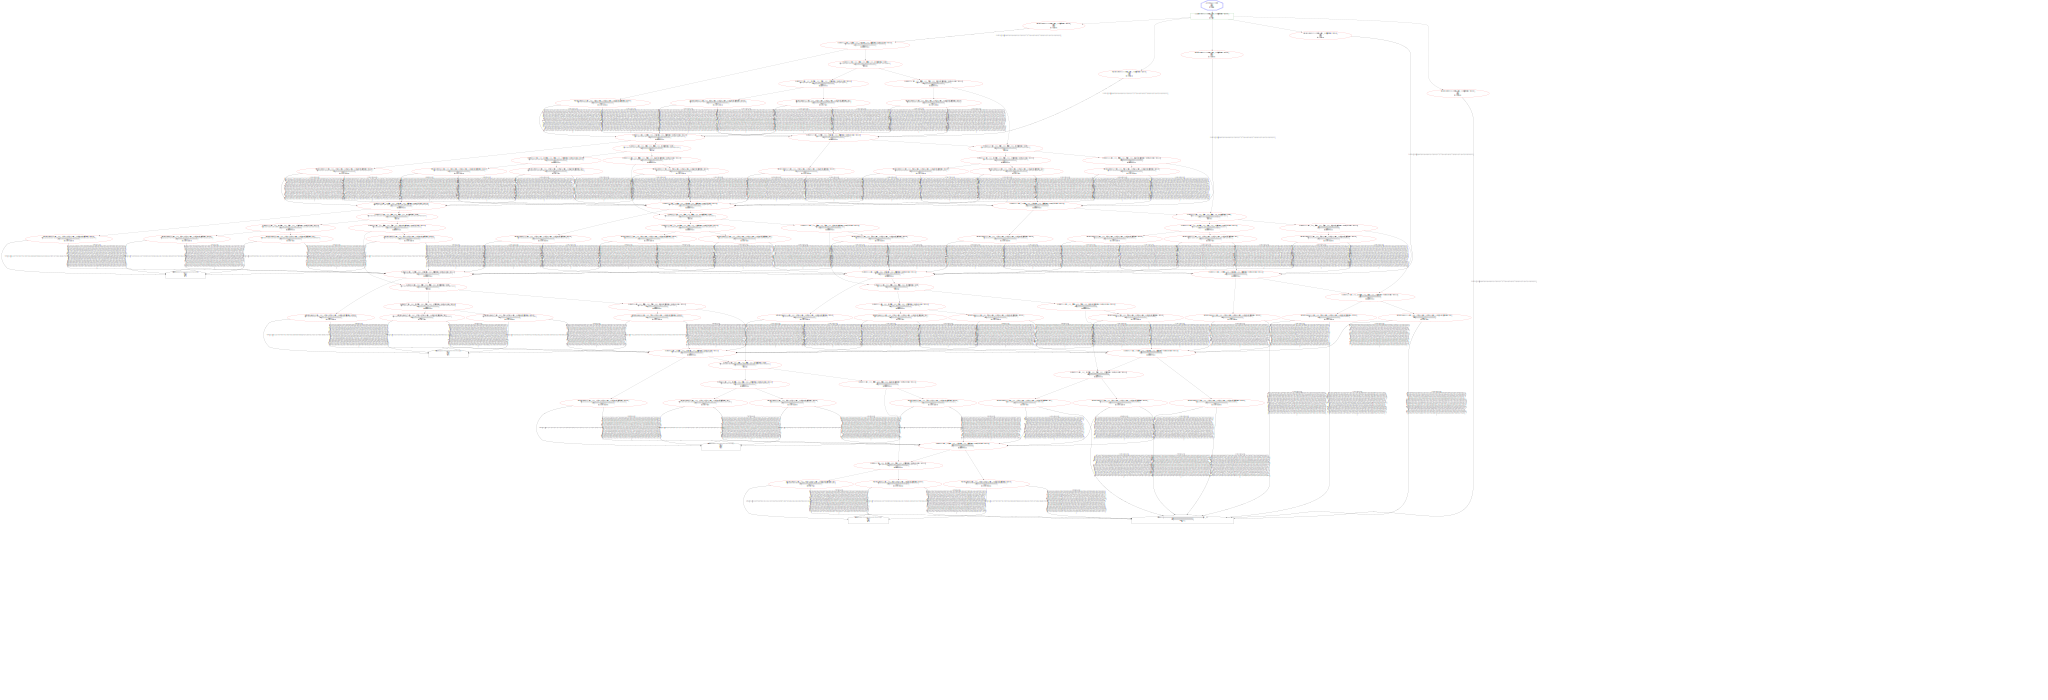

In [10]:
# Display sample
built_dataset.samples[0].draw(img_type="svg")

In [11]:
epochs = 300

losses = []

for epoch in range(epochs):
    res, sample_count = model(built_dataset.samples, train=True)

    acc_loss = 0
    
    for target, output, loss in res:
        acc_loss += loss
        
    print("Epoch", epoch, "Loss:", acc_loss, "Mean loss:", acc_loss / sample_count)
    losses.append(acc_loss)

Epoch 0 Loss: 6.083160490000402 Mean loss: 0.06083160490000403
Epoch 1 Loss: 2.2840650084958822 Mean loss: 0.022840650084958822
Epoch 2 Loss: 1.4858856718724218 Mean loss: 0.014858856718724217
Epoch 3 Loss: 1.1878093438444064 Mean loss: 0.011878093438444063
Epoch 4 Loss: 1.0768520829935488 Mean loss: 0.010768520829935489
Epoch 5 Loss: 1.0123350387217116 Mean loss: 0.010123350387217116
Epoch 6 Loss: 0.9656553714956269 Mean loss: 0.009656553714956268
Epoch 7 Loss: 0.9324729977460346 Mean loss: 0.009324729977460346
Epoch 8 Loss: 0.9022516771087317 Mean loss: 0.009022516771087317
Epoch 9 Loss: 0.8790322979991856 Mean loss: 0.008790322979991856
Epoch 10 Loss: 0.8534107807542335 Mean loss: 0.008534107807542334
Epoch 11 Loss: 0.8324739065199404 Mean loss: 0.008324739065199404
Epoch 12 Loss: 0.807513596480301 Mean loss: 0.008075135964803009
Epoch 13 Loss: 0.7868600054668282 Mean loss: 0.007868600054668282
Epoch 14 Loss: 0.7617469762882513 Mean loss: 0.007617469762882512
Epoch 15 Loss: 0.738510

Epoch 126 Loss: 0.14895697766636043 Mean loss: 0.0014895697766636044
Epoch 127 Loss: 0.14882017999683764 Mean loss: 0.0014882017999683765
Epoch 128 Loss: 0.15011007733618287 Mean loss: 0.0015011007733618286
Epoch 129 Loss: 0.1452656301834221 Mean loss: 0.001452656301834221
Epoch 130 Loss: 0.1473628173633166 Mean loss: 0.001473628173633166
Epoch 131 Loss: 0.14376499782897112 Mean loss: 0.0014376499782897112
Epoch 132 Loss: 0.1437787506164816 Mean loss: 0.001437787506164816
Epoch 133 Loss: 0.15047429676666596 Mean loss: 0.0015047429676666596
Epoch 134 Loss: 0.13399597816249426 Mean loss: 0.0013399597816249427
Epoch 135 Loss: 0.14216185125057132 Mean loss: 0.0014216185125057131
Epoch 136 Loss: 0.1374803619545433 Mean loss: 0.001374803619545433
Epoch 137 Loss: 0.13166273404984574 Mean loss: 0.0013166273404984575
Epoch 138 Loss: 0.13153480516568078 Mean loss: 0.0013153480516568078
Epoch 139 Loss: 0.1286446283226079 Mean loss: 0.001286446283226079
Epoch 140 Loss: 0.12786214645100585 Mean los

Epoch 254 Loss: 0.09434323371034338 Mean loss: 0.0009434323371034338
Epoch 255 Loss: 0.09450034617171188 Mean loss: 0.0009450034617171188
Epoch 256 Loss: 0.12156915306071207 Mean loss: 0.0012156915306071208
Epoch 257 Loss: 0.1392795370284876 Mean loss: 0.0013927953702848762
Epoch 258 Loss: 0.08929249353623421 Mean loss: 0.0008929249353623421
Epoch 259 Loss: 0.09398243261584227 Mean loss: 0.0009398243261584227
Epoch 260 Loss: 0.08239302578103064 Mean loss: 0.0008239302578103064
Epoch 261 Loss: 0.08789133305047872 Mean loss: 0.0008789133305047872
Epoch 262 Loss: 0.08317340457395869 Mean loss: 0.0008317340457395869
Epoch 263 Loss: 0.08239071055252592 Mean loss: 0.0008239071055252592
Epoch 264 Loss: 0.08302280720106538 Mean loss: 0.0008302280720106538
Epoch 265 Loss: 0.08362600675293391 Mean loss: 0.0008362600675293391
Epoch 266 Loss: 0.08375331041873296 Mean loss: 0.0008375331041873297
Epoch 267 Loss: 0.08372338607674298 Mean loss: 0.0008372338607674298
Epoch 268 Loss: 0.0836066704860989 

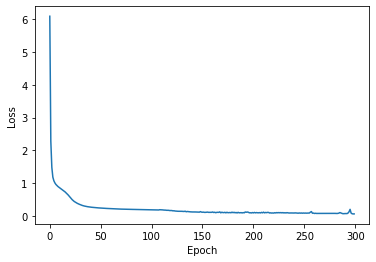

In [12]:
import matplotlib.pyplot as plt


plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(losses)

In [13]:
test_queries = [R.predict for _ in examples]
test_dataset = Dataset(examples, test_queries)

test_build_dataset = model.build_dataset(test_dataset)


predictions = []

for y_hat in model(test_build_dataset.samples, train=False):
    predictions.append([y_hat])

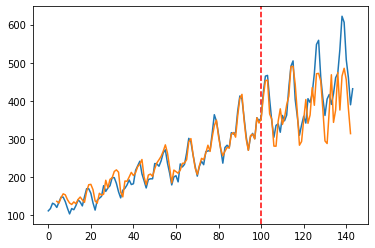

In [14]:
plt.axvline(x=train_size, c='r', linestyle='--')


shifted_predictions = [[np.nan] for _ in range(window_size)]
shifted_predictions.extend(predictions)

plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(scaler.inverse_transform(shifted_predictions))


plt.show()